# MFHT Rolling Windows Plot

In [1]:
import sqlite3

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime

from stabilvol.utility import functions as f

DATABASE = '../data/processed/trapezoidal_selection/stabilvol_filtered.sqlite'
# Connect to the SQLite database
conn = sqlite3.connect(DATABASE)
cur = conn.cursor()

In [75]:
import os
print(os.getcwd())
os.path.exists(DATABASE)

os.path.exists('../visualization/dynamics/rolling_windows/')

/home/fedesss/UNIPA/ECONOPHYSICS/stabilvol/notebooks


True

In [3]:
MARKETS = ["UN", "UW", "LN", "JT"]
START_DATE = "1980-01-01"
END_DATE = "2022-07-01"

START_LEVELS = [-2.0, -1.0, -0.5, -0.2, -0.1, 0.1, 0.2, 0.5, 1.0, 2.0]
DELTAS = [2.0, 1.0, 0.5, 0.2, 0.1, -0.1, -0.2, -0.5, -1.0, -2.0]
LEVELS = {
    (start, round(start+delta, 2)) for start in START_LEVELS for delta in DELTAS
}
LEVELS = sorted(LEVELS)

VOL_LIMIT= 0.5  # Change this will change all the pickle files, remember to re-generate them

WINDOWS_DURATION = 90  # days

In [4]:
def select_bins(df, max_n=1000):
    nbins = 25
    
    while True:
        # Use qcut to bin 'Volatility' values
        df['Bins'] = pd.qcut(df['Volatility'], nbins, duplicates='drop')
        
        # Group by the bins and calculate the mean and standard error of 'value'
        grouped = df.groupby('Bins', observed=True)['FHT'].agg(['mean', error_on_the_mean, 'size'])
        count = grouped['size'].min()
        
        if count < max_n or nbins > 1000:
            break
        else:
            nbins += 20
    return grouped, nbins

def error_on_the_mean(values):
    return np.std(values)/np.sqrt(len(values))

In [5]:
def query_binned_data(market: str, start_date:str, end_date:str = None, vol_limit:float = 0.5, t1_string:str = "m0p5", t2_string:str = "m1p5"):
    grouped_data = None
    end_date = '2023-01-01' if end_date is None else end_date
    try:            
        # Write the SQL query
        query = f'''
        SELECT *
        FROM stabilvol_{t1_string}_{t2_string}
        WHERE Volatility < {vol_limit} 
        AND Market = "{market}"
        AND start >= "{start_date}"
        AND end <= "{end_date}"    
        '''
        # Load the FHT data from the database
        df = pd.read_sql_query(query, conn)
    except pd.errors.DatabaseError:
        print(f'No data for market {market} with thresholds {t1_string}-{t2_string}')
        nbins = 0
    else:
        if len(df) > 50:
            return  select_bins(df)
        else:
            raise ValueError(f'Not enough data for market {market} with thresholds {t1_string}-{t2_string} from {start_date} to {end_date}')

In [6]:
def create_dataset(markets, windows, t1_string, t2_string):
    outcasts = {market: [] for market in markets}
    df = pd.DataFrame()
    for market in markets:
        for start_date, end_date in tqdm(windows, desc=market):
            try:
                mfht, nbins = query_binned_data(market, start_date, end_date, VOL_LIMIT, t1_string=t1_string, t2_string=t2_string)         
            except ValueError:
                outcasts[market].append((start_date, end_date))
            else:
                mfht['start'] = start_date
                mfht['end'] = end_date
                mfht['market'] = market
                df = pd.concat([df, mfht.reset_index()])
                
    return df, outcasts

In [7]:
def take_maxs(market, windows, coefficients, regenerate=False):
    if regenerate:  
        max_values = np.zeros((len(coefficients), len(windows)))
        for i, (t1_string, t2_string) in enumerate(coefficients):
            df = pd.read_pickle(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_200bins_{VOL_LIMIT}.pickle')
            for j, (start_date, end_date) in tqdm(enumerate(windows), desc=market):
                mfht = df[(df['start'] == start_date) & (df['end'] == end_date)]       
                if not mfht.empty:            
                    max_values[i, j] = mfht['mean'].max()
                        
        np.save(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.npy', max_values)
    else:
        max_values = np.load(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.npy')
    return max_values

In [8]:
def generate_quarters(start_date, end_date, freq='Q'):
    # Generate all quarters between start and end date
    quarters = list(pd.date_range(start_date, end_date, freq=freq))
    if quarters[0].date() > start_date.date():
        quarters.insert(0, start_date)
    if quarters[-1].date() < end_date.date():
        quarters.append(pd.to_datetime(end_date))

    return pd.to_datetime(quarters)


def add_ticks(ax, windows, coeff, outcasts, highlights=True):
    label_dates = [start_date for start_date, end_date in windows]
    label_dates.append(windows[-1][1])
    label_dates = pd.to_datetime(label_dates)
    quarters = generate_quarters(label_dates[0], label_dates[-1], 'Y')
    tick_coords = []
    for qdate in quarters:
        if np.where(label_dates == qdate)[0].size > 0:
            tick_coords.append(np.where(label_dates == qdate)[0][0])
    ax.set_xticks(tick_coords, labels=[label_dates[j].strftime('%Y-%m-%d') for j in tick_coords], minor=False, 
                  fontsize=11, rotation=90, rotation_mode='anchor', ha='right', va='center_baseline')
    ax.set_title(' '.join([r'$\theta_i$=', f.numerify_threshold(coeff[0]), r'/ $\theta_f$=', f.numerify_threshold(coeff[1])]), fontsize=12)
    # Remove yticks
    ax.yaxis.set_ticks([])
    
    outcast_dates = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in outcasts]
    for outcast in outcast_dates:
        # Find the indices of the start and end labels
        start_index = np.where(label_dates <= outcast[0])
        # Since only the end date is labeled, if the first start date is an outcast, it must be set manually
        start_index = start_index[0][-1] if len(start_index[0]) > 0 else 0
        end_index = np.where(label_dates >= outcast[1])[0][0]
        ax.axvspan(start_index-0.5, end_index-0.5, color='black')
    
    if highlights:
        # Find the indices of the start and end labels
        start_index = np.where(label_dates <= pd.to_datetime('2006-12-31'))[0][-1]
        end_index = np.where(label_dates >= pd.to_datetime('2008-12-31'))[0][0]
    
        # Add vertical lines at the start and end of the region
        ax.axvline(start_index, color='k', linestyle='--', linewidth=1.5)
        ax.axvline(end_index, color='k', linestyle='--', linewidth=1.5)


def plot_rolling_heatmap(coefficients, windows, maxs=None, outcasts=None, **kwargs):
    if outcasts is None:
        outcasts = {(t1, t2): [] for t1, t2 in coefficients}
        search_outcasts = True
    else:
        search_outcasts = False
    if kwargs.get('latex', False):    
        # Use LaTeX for text rendering
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = 'serif'
    
    fig, axs = plt.subplots(len(coefficients), figsize=(12, 4.5), sharex=True)
    if kwargs.get('suptitle', None) is not None:
        fig.suptitle(kwargs.get('suptitle'), fontsize=16)

    max_values = np.zeros((len(coefficients), len(windows))) if maxs is None else maxs
    

    for i, (coeff, ax) in enumerate(zip(coefficients, axs.flatten())):
        for j, (start_date, end_date) in enumerate(windows):
            if maxs is None:
                data = pd.read_pickle(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{coeff[0]}_{coeff[1]}_{VOL_LIMIT}.pickle')
                # Calculate the peaks
                mfht = data[(data['start'] == start_date) & (data['end'] == end_date)]       
                if mfht.empty:            
                    outcasts[coeff].append((start_date, end_date))
                else:
                    max_values[i, j] = mfht['mean'].max()
            elif search_outcasts:
                # See where the max is zero and label it as outcast
                if max_values[i, j] == 0:
                    outcasts[coeff].append((start_date, end_date))
                

        im = ax.imshow(max_values[i].reshape(1, -1), cmap='coolwarm', aspect='auto', vmin=max_values[i].min(), vmax=max_values[i].max())
        # Add ticks to the plot
        add_ticks(ax, windows, coeff, outcasts[coeff])
        # Set the colorbar for each plot showing only maximum and minimum values
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.01, aspect=8)
        cbar.set_ticks([max_values[i].min(), max_values[i].mean(), max_values[i].max()])
    
    # axs[0].text(0.57, 1.1, '2006-12-31', fontsize=11, transform=axs[0].transAxes, horizontalalignment='left')
    # axs[0].text(0.73, 1.1, '2008-12-31', fontsize=11, transform=axs[0].transAxes, horizontalalignment='right')
    
    fig.tight_layout()
    
    # Add a colorbar
    # cbar = fig.colorbar(im, ax=axs.ravel().tolist(), pad=0.01)
    # cbar.set_label('Maximum MFHT', rotation=270, labelpad=15)

    plt.show()
    return fig, outcasts

## Rolling Windows

In [9]:
def roll_windows(duration=90,  start_date=None, end_date=None):
    # Define the start and end dates
    start_date = datetime.date(1980, 1, 1) if start_date is None else start_date
    end_date = datetime.date(2022, 7, 1) if end_date is None else end_date
    
    half_win_len = pd.to_timedelta(duration//2, 'D')
    start = start_date + half_win_len
    end = end_date - half_win_len
    centers = pd.date_range(start, end, freq='D')
    return [(mid - half_win_len, mid + half_win_len) for mid in centers]

In [10]:
windows = roll_windows(duration=WINDOWS_DURATION, start_date=datetime.date(1985, 1, 1), end_date=datetime.date(2022, 12, 31))
len(windows)

13789

In [11]:
# If change this, remember to re-generate all the max_values (regenerate=True)
coefficients = [
    ("2p6", "2p2"),
    ("1p8", "1p4"),
    ("1p0", "0p6"),
    ("m1p0", "m0p6"),
    ("m1p8", "m1p4"),
    ("m2p6", "m2p2"),
]

df_maxs = []

## Premade Models

In [12]:
experiments_map = [
    dict(
        start_levels = [1.4, 1., 0.6],
        deltas = [-0.2, -0.4, -0.8]
    ),
    dict(
        start_levels = [1.4, 1., 0.6],
        deltas = [0.2, 0.4, 0.8]
    ),
    dict(
        start_levels = [-1.4, -1., -0.6],
        deltas = [0.2, 0.4, 0.8]
    ),
    dict(
        start_levels = [-1.4, -1., -0.6],
        deltas = [-0.2, -0.4, -0.8]
    ),
    dict(
        start_levels = [3.0, 2.6, 2.2, 1.8],
        deltas = [-0.2, -0.4, -0.8]
    ),
    dict(
        start_levels = [-3.0, -2.6, -2.2, -1.8],
        deltas = [0.2, 0.4, 0.8]
    ),
]
levels = {(round(start, 2), round(start+delta, 2)) for start in experiments_map[0]['start_levels'] for delta in experiments_map[0]['deltas']}
levels = sorted(levels)

In [21]:
df_markets = {}
for i, market in enumerate(MARKETS):
    df_maxs = []
    for j in range((len(experiments_map))):
        try:
            max_values = np.load(f'../data/processed/dynamics/{market}_rolling_90d_MFHT_peaks_{j+1}.npy')
            outcasts = np.load(f'../data/processed/dynamics/{market}_rolling_90d_MFHT_outcasts_{j+1}.npy')
        except FileNotFoundError:
            print(f'File not found for market {market} experiment {j+1}, skipping...')
            continue

        # Mask outcasts
        max_values[outcasts == 1] = np.nan
        coefficients = sorted({(round(start, 2), round(start+delta, 2)) for start in experiments_map[j]['start_levels'] for delta in experiments_map[j]['deltas']})
        start_delta = pd.MultiIndex.from_tuples([(l[0], round(l[1] - l[0], 2)) for l in coefficients], names=['start', 'delta'])
        df = pd.DataFrame(max_values.T, columns=start_delta)
        df_maxs.append(df)
    df_maxs = pd.concat(df_maxs, axis=1)
    df_markets[market] = df_maxs

df_markets = pd.concat(df_markets, keys=df_markets.keys(), names=['market', 'window'])
df_markets.to_pickle(f'../data/processed/dynamics/rolling_90d_MFHT_peaks_all_markets.pkl')

print(f'Starting Thresholds used:\n{df_markets.columns.get_level_values(0).unique().sort_values()}')

Starting Thresholds used:
Index([-3.0, -2.6, -2.2, -1.8, -1.4, -1.0, -0.6, 0.6, 1.0, 1.4, 1.8, 2.2, 2.6,
       3.0],
      dtype='float64', name='start')


### Filter Data

In [53]:
filter_data = True
if filter_data:
    df = df_markets.drop(columns=[-3.0, -2.6, -2.2, 2.2, 2.6, 3.0], level=0)
else:
    df = df_markets

In [54]:
high_thresholds = sorted({t for t in df.columns.get_level_values(0).unique() if t > 0}, reverse=True)
crashes = sorted({d for d in df.columns.get_level_values(1).unique() if d < 0})
low_thresholds = sorted({t for t in df.columns.get_level_values(0).unique() if t < 0}, reverse=True)
rallies = sorted({d for d in df.columns.get_level_values(1).unique() if d > 0})
thresholds = high_thresholds + low_thresholds
deltas = crashes + rallies
print('High Thresholds:', high_thresholds)
print('Low Thresholds:', low_thresholds)


High Thresholds: [1.8, 1.4, 1.0, 0.6]
Low Thresholds: [-0.6, -1.0, -1.4, -1.8]


In [67]:
# Create xlabels (windows centered at the first day of each year)
xtickslabels = []
xticks = []
for year in range(1985, 2022):
    for i, w in enumerate(windows):
        date = w[0] + (w[1] - w[0]) / 2
        if date.year == year:
            xtickslabels.append(date.strftime('%Y'))
            xticks.append(i)
            break
ylabels = high_thresholds + low_thresholds

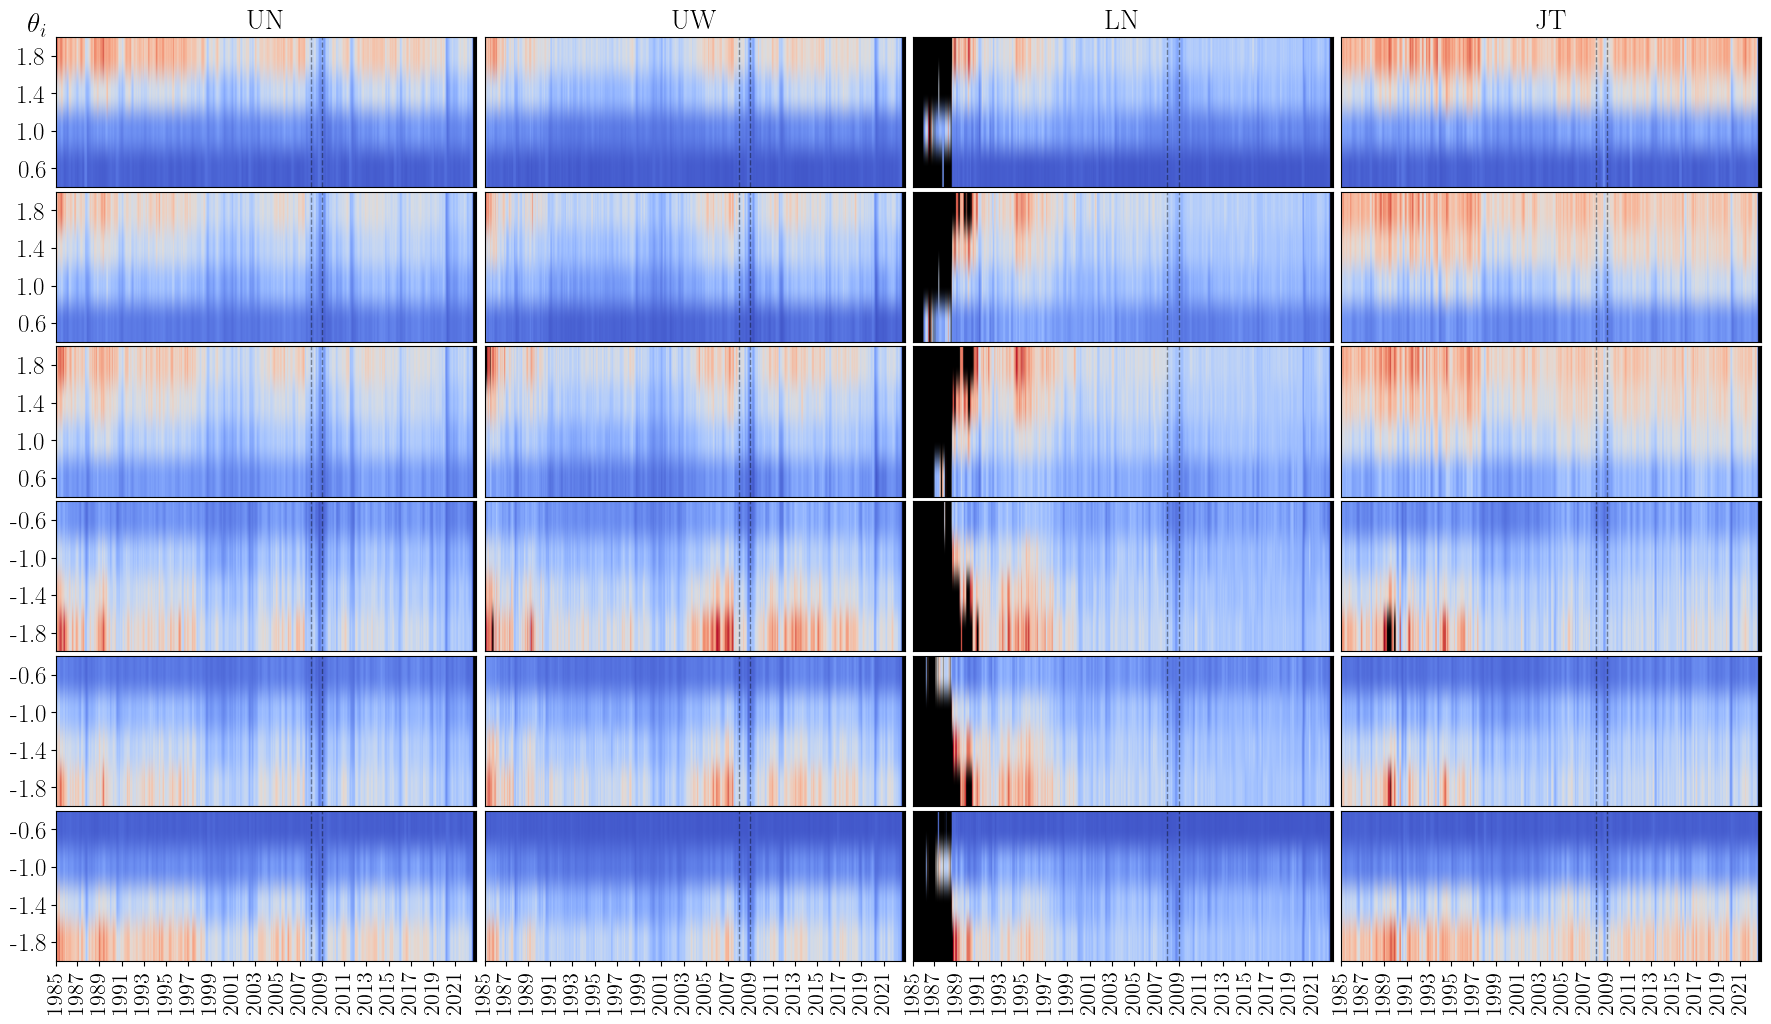

In [ ]:
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif'
})

fig = plt.figure(figsize=(22, 12))
gs = gridspec.GridSpec(6, 4, width_ratios=[1, 1, 1, 1], 
                       hspace=0.03, wspace=0.02)

axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(4)] for i in range(6)])

# Create axes for colorbars
# cbar_axs = [fig.add_subplot(gs[i, 4]) for i in range(6)]
# for cax in cbar_axs:
#     cax.axis('off')

# Create colormap with black for masked values
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color='black')

for i, market in enumerate(MARKETS):

    for j, delta in enumerate(deltas):
        ax = axs[j, i]
        if j < len(crashes):
            data = df.loc[market, (high_thresholds, delta)].T
            # ax.set_yticks(ax.get_yticks(), high_thresholds)
        else:
            data = df.loc[market, (low_thresholds, delta)].T
            # ax.set_yticks(ax.get_yticks(), low_thresholds)
        im = ax.imshow(data, cmap=cmap, aspect='auto', vmin=data.min().min(), vmax=data.max().max())
        # Add colorbar
        # if i == len(MARKETS) - 1:
        #     cbar = fig.colorbar(im, ax=cbar_axs[j], orientation='vertical', use_gridspec=True)
        #     cbar.ax.set_title(f"$d={delta}$", fontsize=14)
        # Set titles
        if j == 0:
            ax.set_title(market, fontsize=20)
        # if j == len(deltas) - 1:
            # Set xlabels and ylabels
        yticks = ax.get_yticks()

for i in range(len(MARKETS)):
    for j in range(len(deltas)):
        ax = axs[j, i]
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_yticks(np.arange(len(high_thresholds)), high_thresholds if j < len(crashes) else low_thresholds, fontsize=18)
        if j == len(deltas) - 1:
            ax.set_xticks(xticks[::2], xtickslabels[::2], rotation=90, fontsize=16)
        # Add dashed lines for 2007-2008 crisis
        start_crisis_window = np.where(np.array(xtickslabels) == '2008')[0][0]
        end_crisis_window = np.where(np.array(xtickslabels) == '2009')[0][0]
        ax.axvline(xticks[start_crisis_window], color='k', linestyle='--', linewidth=1, alpha=0.4)
        ax.axvline(xticks[end_crisis_window], color='k', linestyle='--', linewidth=1, alpha=0.4)

fig.text(0.112, 0.9, '$\\theta_i$', fontsize=20, verticalalignment='top', horizontalalignment='left')

fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_90d_MFHT_peaks_grid.png')
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_90d_MFHT_peaks_grid.pdf')

plt.show()


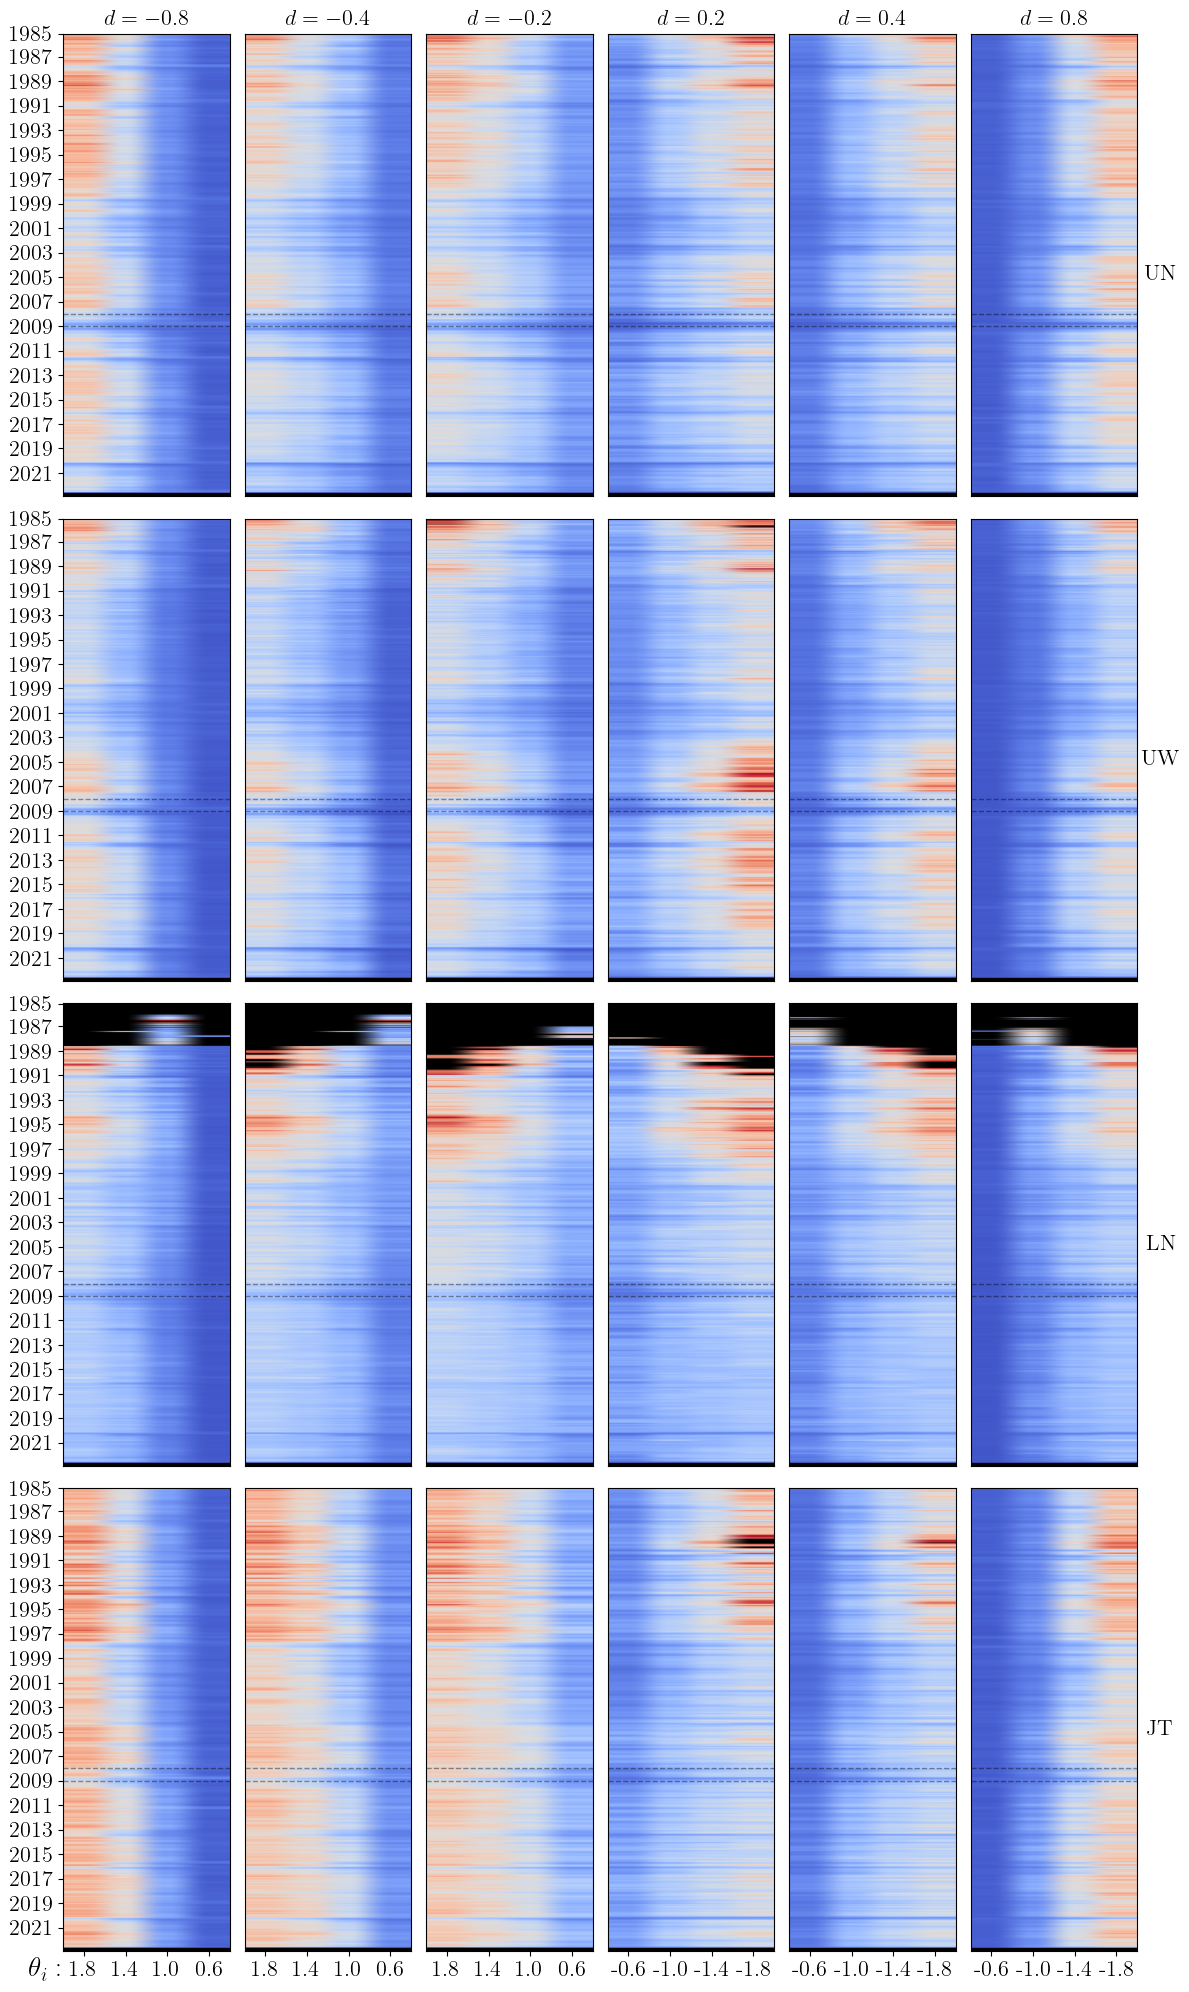

In [109]:
fig, axs = plt.subplots(4, 6, figsize=(12, 20), layout='tight')

# Create axes for colorbars
# cbar_axs = [fig.add_subplot(gs[i, 4]) for i in range(6)]
# for cax in cbar_axs:
#     cax.axis('off')

# Create colormap with black for masked values
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color='black')

for i, market in enumerate(MARKETS):

    for j, delta in enumerate(deltas):
        ax = axs[i, j]
        if j < len(crashes):
            data = df.loc[market, (high_thresholds, delta)]
            # ax.set_yticks(ax.get_yticks(), high_thresholds)
        else:
            data = df.loc[market, (low_thresholds, delta)]
            # ax.set_yticks(ax.get_yticks(), low_thresholds)
        im = ax.imshow(data, cmap=cmap, aspect='auto', vmin=data.min().min(), vmax=data.max().max())
        # Add colorbar
        # if i == len(MARKETS) - 1:
        #     cbar = fig.colorbar(im, ax=cbar_axs[j], orientation='vertical', use_gridspec=True)
        #     cbar.ax.set_title(f"$d={delta}$", fontsize=14)
        # Set titles
        
        # if j == len(deltas) - 1:
            # Set xlabels and ylabels
        yticks = ax.get_yticks()

for i, market in enumerate(MARKETS):
    for j, delta in enumerate(deltas):
        ax = axs[i, j]
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(f'$d = {delta}$', fontsize=16)
        elif i == len(MARKETS) - 1:
            ax.set_xticks(np.arange(len(high_thresholds)), high_thresholds if j < len(crashes) else low_thresholds, fontsize=16)
        if j == 0:
            ax.set_yticks(xticks[::2], xtickslabels[::2], rotation=0, fontsize=16)
        elif j == len(deltas) - 1:
            ax.set_ylabel(market, labelpad=17, rotation=0, fontsize=16)
            ax.yaxis.set_label_position('right')
        # Add dashed lines for 2007-2008 crisis
        start_crisis_window = np.where(np.array(xtickslabels) == '2008')[0][0]
        end_crisis_window = np.where(np.array(xtickslabels) == '2009')[0][0]
        ax.axhline(xticks[start_crisis_window], color='k', linestyle='--', linewidth=1, alpha=0.4)
        ax.axhline(xticks[end_crisis_window], color='k', linestyle='--', linewidth=1, alpha=0.4)

fig.text(0.028, 0.0188, '$\\theta_i :$', fontsize=20, verticalalignment='top', horizontalalignment='left')

fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_90d_MFHT_peaks_grid_vertical.png')
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_90d_MFHT_peaks_grid_vertical.pdf')

plt.show()


In [101]:
np.where(np.array(xtickslabels) == '2009-01-01')[0][0]

np.int64(24)

In [40]:
ax.get_xticklabels()

[Text(-2500.0, 0, '-2500.0'),
 Text(0.0, 0, '0.0'),
 Text(2500.0, 0, '2500.0'),
 Text(5000.0, 0, '5000.0'),
 Text(7500.0, 0, '7500.0'),
 Text(10000.0, 0, '10000.0'),
 Text(12500.0, 0, '12500.0'),
 Text(15000.0, 0, '15000.0')]

## UN

In [12]:
market = "UN"

In [ ]:
regenerate = True
for t1_string, t2_string in coefficients:
    filepath = f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_200bins_{VOL_LIMIT}.pickle'
    if not os.path.exists(filepath) or regenerate:
        print(f"Generating {market} with thresholds {t1_string}-{t2_string}")
        # Data must be regenerate
        df, outcasts = create_dataset([market], windows, t1_string, t2_string)
        print(f"There are {len(outcasts[market])} outcasts")
        # df['thresholds'] = f'{t1_string}_{t2_string}'
        df.to_pickle(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_{VOL_LIMIT}.pickle')
regenerate = False

Generating UN with thresholds 2p6-2p2


UN: 100%|██████████| 15342/15342 [11:38<00:00, 21.98it/s]


There are 0 outcasts
Generating UN with thresholds 1p8-1p4


UN: 100%|██████████| 15342/15342 [31:50<00:00,  8.03it/s]


There are 0 outcasts
Generating UN with thresholds 1p0-0p6


UN:  87%|████████▋ | 13385/15342 [1:36:19<15:01,  2.17it/s]

In [ ]:
max_values = take_maxs(market, windows, coefficients, regenerate=False)
print(max_values.shape)
print("MAX VALUES")
for coeffs, win in zip(coefficients, np.array(windows)[list(max_values.argmax(axis=1))]):
    print(f"\t{market} {f.numerify_threshold(coeffs[0])}/{f.numerify_threshold(coeffs[1])}: {win[0]} - {win[1]}")
print("MIN VALUES")
for coeffs, win in zip(coefficients, np.array(windows)[list(max_values.argmin(axis=1))]):
    print(f"\t{market} {f.numerify_threshold(coeffs[0])}/{f.numerify_threshold(coeffs[1])}: {win[0]} - {win[1]}")
    
maxs = np.array(windows)[max_values.argmax(axis=1)]
mins = np.array(windows)[max_values.argmin(axis=1)]
for i in range(len(maxs)):
    row = {
        'market': market,
        'thresholds': f'{coefficients[i][0]}_{coefficients[i][1]}',
        'start_max': maxs[i][0],
        'end_max': maxs[i][1],
        'start_min': mins[i][0],
        'end_min': mins[i][1],
    }
    df_maxs.append(row)

max_values

(1, 15342)
MAX VALUES
	UN 0.5/1.5: 1988-06-22 00:00:00 - 1989-06-21 00:00:00
MIN VALUES
	UN 0.5/1.5: 2021-07-03 00:00:00 - 2022-07-02 00:00:00


array([[10.4       ,  9.97142857,  9.72222222, ...,  0.        ,
         0.        ,  0.        ]], shape=(1, 15342))

AttributeError: 'Axes' object has no attribute 'flatten'

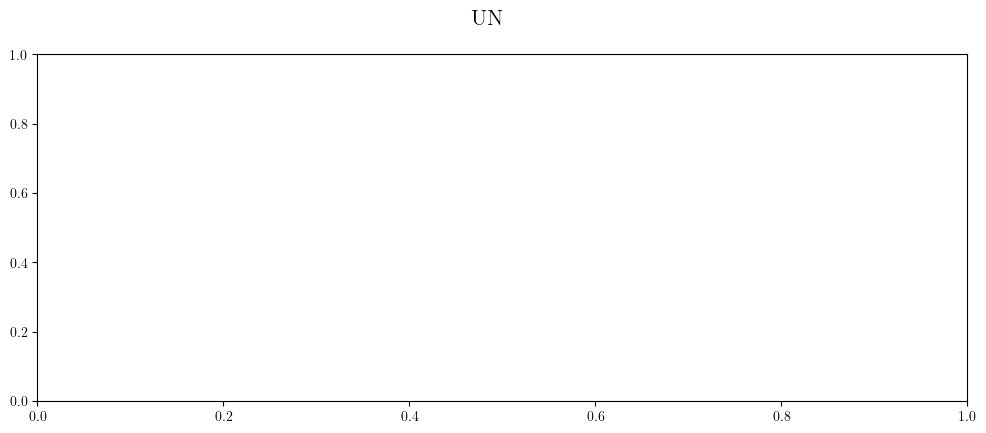

In [ ]:
fig, errors = plot_rolling_heatmap(coefficients, windows[:-95], max_values[:, :-95], outcasts if regenerate else None, latex=True, suptitle=market)

In [ ]:
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.pdf', bbox_inches='tight')

## UW

In [ ]:
market = "UW"

In [ ]:
regenerate = False
for t1_string, t2_string in coefficients:
    if not os.path.exists(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_{VOL_LIMIT}.pickle') or regenerate:
        print(f"Generating {market} with thresholds {t1_string}-{t2_string}")
        # Data must be regenerate
        df, outcasts = create_dataset([market], windows, t1_string, t2_string)
        print(f"There are {len(outcasts[market])} outcasts")
        # df['thresholds'] = f'{t1_string}_{t2_string}'
        df.to_pickle(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_{VOL_LIMIT}.pickle')
regenerate = False

In [ ]:
max_values = take_maxs(market, windows, coefficients, regenerate=True)
print(max_values.shape)
print("MAX VALUES")
for coeffs, win in zip(coefficients, np.array(windows)[list(max_values.argmax(axis=1))]):
    print(f"\t{market} {f.numerify_threshold(coeffs[0])}/{f.numerify_threshold(coeffs[1])}: {win[0]} - {win[1]}")
print("MIN VALUES")
for coeffs, win in zip(coefficients, np.array(windows)[list(max_values.argmin(axis=1))]):
    print(f"\t{market} {f.numerify_threshold(coeffs[0])}/{f.numerify_threshold(coeffs[1])}: {win[0]} - {win[1]}")
    
maxs = np.array(windows)[max_values.argmax(axis=1)]
mins = np.array(windows)[max_values.argmin(axis=1)]
for i in range(len(maxs)):
    row = {
        'market': market,
        'thresholds': f'{coefficients[i][0]}_{coefficients[i][1]}',
        'start_max': maxs[i][0],
        'end_max': maxs[i][1],
        'start_min': mins[i][0],
        'end_min': mins[i][1],
    }
    df_maxs.append(row)

UW: 15342it [04:19, 59.03it/s]

(1, 15342)
MAX VALUES
	UW 0.5/1.5: 1984-06-22 00:00:00 - 1985-06-21 00:00:00
MIN VALUES
	UW 0.5/1.5: 1980-01-01 00:00:00 - 1980-12-30 00:00:00


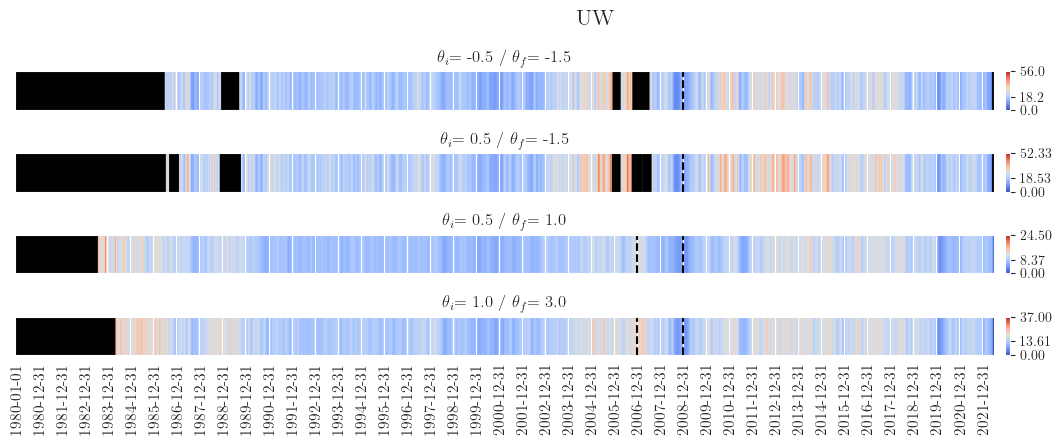

In [ ]:
fig, errors = plot_rolling_heatmap(coefficients, windows[:-95], max_values[:, :-95], outcasts if regenerate else None, latex=True, suptitle=market)

In [ ]:
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.pdf', bbox_inches='tight')

## LN

In [ ]:
market = "LN"

In [ ]:
regenerate = False
for t1_string, t2_string in coefficients:
        df = pd.DataFrame()
        if not os.path.exists(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_{VOL_LIMIT}.pickle') or regenerate:
            print(f"Generating {market} with thresholds {t1_string}-{t2_string}")
            # Data must be regenerate
            df, outcasts = create_dataset([market], windows, t1_string, t2_string)
            print(f"There are {len(outcasts[market])} outcasts")
            # df['thresholds'] = f'{t1_string}_{t2_string}'
            df.to_pickle(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_{VOL_LIMIT}.pickle')
regenerate = False

In [ ]:
max_values = take_maxs(market, windows, coefficients, regenerate=True)
print("MAX VALUES")
for coeffs, win in zip(coefficients, np.array(windows)[list(max_values.argmax(axis=1))]):
    print(f"\t{market} {f.numerify_threshold(coeffs[0])}/{f.numerify_threshold(coeffs[1])}: {win[0]} - {win[1]}")
print("MIN VALUES")
for coeffs, win in zip(coefficients, np.array(windows)[list(max_values.argmin(axis=1))]):
    print(f"\t{market} {f.numerify_threshold(coeffs[0])}/{f.numerify_threshold(coeffs[1])}: {win[0]} - {win[1]}")

maxs = np.array(windows)[max_values.argmax(axis=1)]
mins = np.array(windows)[max_values.argmin(axis=1)]
for i in range(len(maxs)):
    row = {
        'market': market,
        'thresholds': f'{coefficients[i][0]}_{coefficients[i][1]}',
        'start_max': maxs[i][0],
        'end_max': maxs[i][1],
        'start_min': mins[i][0],
        'end_min': mins[i][1],
    }
    df_maxs.append(row)

LN: 15342it [03:36, 70.95it/s]


MAX VALUES
	LN 0.5/1.5: 1987-07-11 00:00:00 - 1988-07-09 00:00:00
MIN VALUES
	LN 0.5/1.5: 1980-01-01 00:00:00 - 1980-12-30 00:00:00


In [ ]:
fig, errors = plot_rolling_heatmap(coefficients, windows[:-95], max_values[:, :-95], outcasts if regenerate else None, latex=True, suptitle=market)

In [ ]:
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.pdf', bbox_inches='tight')

## JT

In [ ]:
market = "JT"

In [ ]:
regenerate = False
for t1_string, t2_string in coefficients:
    df = pd.DataFrame()
    if not os.path.exists(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_{VOL_LIMIT}.pickle') or regenerate:
        print(f"Generating {market} with thresholds {t1_string}-{t2_string}")
        # Data must be regenerate
        df, outcasts = create_dataset([market], windows, t1_string, t2_string)
        print(f"There are {len(outcasts[market])} outcasts")
        # df['thresholds'] = f'{t1_string}_{t2_string}'
        df.to_pickle(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_{VOL_LIMIT}.pickle')
regenerate = False

Generating JT with thresholds 0p5-1p5


JT:   0%|          | 9/15342 [00:07<3:36:13,  1.18it/s]


KeyboardInterrupt: 

In [ ]:
max_values = take_maxs(market, windows, coefficients, regenerate=True)
print("MAX VALUES")
for coeffs, win in zip(coefficients, np.array(windows)[list(max_values.argmax(axis=1))]):
    print(f"\t{market} {f.numerify_threshold(coeffs[0])}/{f.numerify_threshold(coeffs[1])}: {win[0]} - {win[1]}")
print("MIN VALUES")
for coeffs, win in zip(coefficients, np.array(windows)[list(max_values.argmin(axis=1))]):
    print(f"\t{market} {f.numerify_threshold(coeffs[0])}/{f.numerify_threshold(coeffs[1])}: {win[0]} - {win[1]}")
        
maxs = np.array(windows)[max_values.argmax(axis=1)]
mins = np.array(windows)[max_values.argmin(axis=1)]
for i in range(len(maxs)):
    row = {
        'market': market,
        'thresholds': f'{coefficients[i][0]}_{coefficients[i][1]}',
        'start_max': maxs[i][0],
        'end_max': maxs[i][1],
        'start_min': mins[i][0],
        'end_min': mins[i][1],
    }
    df_maxs.append(row)

JT: 15342it [04:31, 56.44it/s]


MAX VALUES
	JT 0.5/1.5: 1980-07-30 00:00:00 - 1981-07-29 00:00:00
MIN VALUES
	JT 0.5/1.5: 2021-07-03 00:00:00 - 2022-07-02 00:00:00


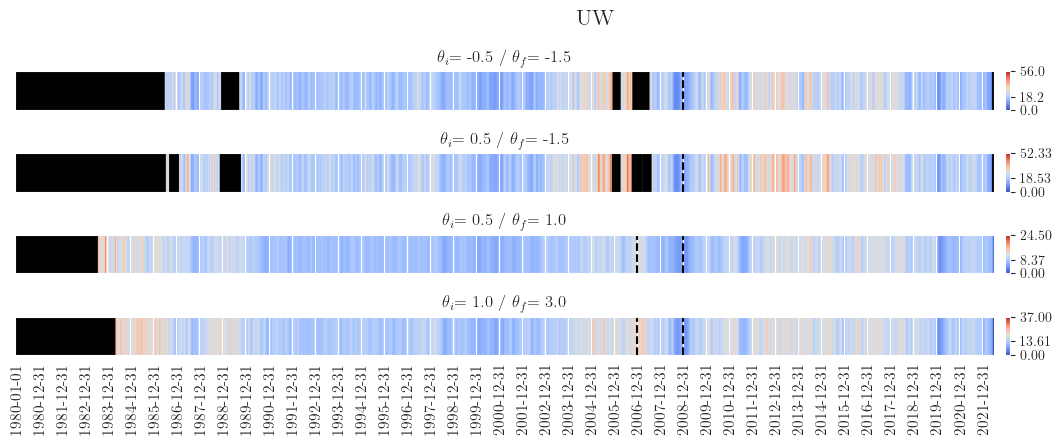

In [ ]:
fig, errors = plot_rolling_heatmap(coefficients, windows[:-95], max_values[:, :-95], outcasts if regenerate else None, latex=True, suptitle=market)

In [ ]:
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.eps', bbox_inches='tight') 
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.pdf', bbox_inches='tight')

## Save the Most-Stable and Less-Stable Windows
### for every Market and every Coefficient

In [ ]:
df_maxs = pd.DataFrame(df_maxs)
df_maxs.to_csv(f'../data/processed/dynamics/maxvalues_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.csv', index=False)